Multiple testing

This script provides an example, where three treatments are compared. It
first performs a one-way ANOVA, to see if there is a difference between the
groups. Then it performs multiple comparisons, to check which of the groups
are different.

This dataset is taken from an R-tutorial, and contains a hypothetical sample
of 30 participants who are divided into three stress reduction treatment
groups (mental, physical, and medical). The values are represented on a
scale that ranges from 1 to 5. This dataset can be conceptualized as a
comparison between three stress treatment programs, one using mental
methods, one using physical training, and one using medication. The values
represent how effective the treatment programs were at reducing
participant's stress levels, with higher numbers indicating higher
effectiveness.

Taken from an example by Josef Perktold (http://jpktd.blogspot.co.at/)

### Copyright(c) 2015, Thomas Haslwanter. All rights reserved, under the CC BY-SA 4.0 International License

In [1]:
# Import standard packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import os

In [2]:
# additional packages
import sys
sys.path.append(os.path.join('..', '..', 'Utilities'))

try:
# Import formatting commands if directory "Utilities" is available
    from ISP_mystyle import showData 
    
except ImportError:
# Ensure correct performance otherwise
    def showData(*options):
        plt.show()
        return

In [3]:
# Other required packages
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.libqsturng import psturng

In [4]:
def setData():
    ''' Set up the data, as a structured array. '''
    
    # The first and last field are 32-bit intergers; the second field is an
    # 8-byte string. Note that here we can also give names to the individual
    # fields!
    data = np.rec.array([
    (  1,   'mental',  2 ),
    (  2,   'mental',  2 ),
    (  3,   'mental',  3 ),
    (  4,   'mental',  4 ),
    (  5,   'mental',  4 ),
    (  6,   'mental',  5 ),
    (  7,   'mental',  3 ),
    (  8,   'mental',  4 ),
    (  9,   'mental',  4 ),
    ( 10,   'mental',  4 ),
    ( 11, 'physical',  4 ),
    ( 12, 'physical',  4 ),
    ( 13, 'physical',  3 ),
    ( 14, 'physical',  5 ),
    ( 15, 'physical',  4 ),
    ( 16, 'physical',  1 ),
    ( 17, 'physical',  1 ),
    ( 18, 'physical',  2 ),
    ( 19, 'physical',  3 ),
    ( 20, 'physical',  3 ),
    ( 21,  'medical',  1 ),
    ( 22,  'medical',  2 ),
    ( 23,  'medical',  2 ),
    ( 24,  'medical',  2 ),
    ( 25,  'medical',  3 ),
    ( 26,  'medical',  2 ),
    ( 27,  'medical',  3 ),
    ( 28,  'medical',  1 ),
    ( 29,  'medical',  3 ),
    ( 30,  'medical',  1 )], dtype=[('idx', '<i4'),
                                    ('Treatment', '|S8'),
                                    ('StressReduction', '<i4')])
    return data

In [5]:
def doAnova(data):
    '''one-way ANOVA'''
    
    df = pd.DataFrame(data)
    model = ols('StressReduction ~ C(Treatment)',df).fit()
    
    anovaResults =  anova_lm(model)
    print(anovaResults)
    if anovaResults['PR(>F)'][0] < 0.05:
        print('One of the groups is different.')

In [9]:
def doTukey(data, multiComp):    
    '''Do a pairwise comparison, and show the confidence intervals'''
    
    print((multiComp.tukeyhsd().summary()))
    
    # Calculate the p-values:
    res2 = pairwise_tukeyhsd(data['StressReduction'], data['Treatment'])
    df = pd.DataFrame(data)
    numData = len(df)
    numTreatments = len(df.Treatment.unique())
    dof = numData - numTreatments
    
    # Show the group names
    print((multiComp.groupsunique))
    
    # Generate a print -------------------
    
    # Get the data
    xvals = np.arange(3)
    res2 = pairwise_tukeyhsd(data['StressReduction'], data['Treatment'])
    errors = np.ravel(np.diff(res2.confint)/2)
    
    # Plot them
    plt.plot(xvals, res2.meandiffs, 'o')
    plt.errorbar(xvals, res2.meandiffs, yerr=errors, fmt='o')
    
    # Put on labels
    pair_labels = multiComp.groupsunique[np.column_stack(res2._multicomp.pairindices)]
    plt.xticks(xvals, pair_labels)
    
    # Format the plot
    xlim = -0.5, 2.5
    plt.hlines(0, *xlim)
    plt.xlim(*xlim)
    plt.title('Multiple Comparison of Means - Tukey HSD, FWER=0.05' +
              '\n Pairwise Mean Differences')          
    
    # Save to outfile, and show the data
    outFile = 'multComp.png'
    showData(outFile)

In [6]:
def Holm_Bonferroni(multiComp):
    ''' Instead of the Tukey's test, we can do pairwise t-test '''
    
    # First, with the "Holm" correction
    rtp = multiComp.allpairtest(stats.ttest_rel, method='Holm')
    print((rtp[0]))
    
    # and then with the Bonferroni correction
    print((multiComp.allpairtest(stats.ttest_rel, method='b')[0]))
    
    # Any value, for testing the program for correct execution
    checkVal = rtp[1][0][0,0]
    return checkVal

In [7]:
def main():
    # Get the data
    data = setData()
    
    # Do a one-way ANOVA
    doAnova(data)
    
    #Then, do the multiple testing
    multiComp = MultiComparison(data['StressReduction'], data['Treatment'])
    
    doTukey(data, multiComp)    # Tukey's HSD test
    checkVal = Holm_Bonferroni(multiComp)  # Alternatives to Tukey's HSD test
    
    return checkVal     # this is only for regression testing of the program

                df     sum_sq   mean_sq         F    PR(>F)
C(Treatment)   2.0  11.666667  5.833333  5.163934  0.012617
Residual      27.0  30.500000  1.129630       NaN       NaN
One of the groups is different.
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1      group2   meandiff  lower  upper  reject
-----------------------------------------------------
b'medical'  b'mental'    1.5     0.3217 2.6783  True 
b'medical' b'physical'   1.0    -0.1783 2.1783 False 
b'mental'  b'physical'   -0.5   -1.6783 0.6783 False 
-----------------------------------------------------
[b'medical' b'mental' b'physical']


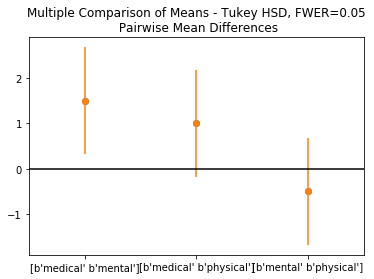

Test Multiple Comparison ttest_rel 
FWER=0.05 method=Holm
alphacSidak=0.02, alphacBonf=0.017
  group1      group2     stat   pval  pval_corr reject
------------------------------------------------------
b'medical'  b'mental'  -4.0249 0.003    0.009    True 
b'medical' b'physical' -1.9365 0.0848   0.1696  False 
b'mental'  b'physical'  0.8321 0.4269   0.4269  False 
------------------------------------------------------
Test Multiple Comparison ttest_rel 
FWER=0.05 method=b
alphacSidak=0.02, alphacBonf=0.017
  group1      group2     stat   pval  pval_corr reject
------------------------------------------------------
b'medical'  b'mental'  -4.0249 0.003    0.009    True 
b'medical' b'physical' -1.9365 0.0848   0.2544  False 
b'mental'  b'physical'  0.8321 0.4269    1.0    False 
------------------------------------------------------


In [10]:
if __name__ == '__main__':
    main()